In [32]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
import os
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')
device='cuda'

In [33]:
min_epochs=10
max_epochs=200
batch_size =1000
learning_rate=0.01
log='logs' # folder where to save logs
name='model' # name of the logs for tensorboard

cpu_size=os.cpu_count()
if batch_size<=cpu_size:
    num_workers = batch_size
else:
    num_workers=cpu_size

In [34]:
# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
mean = (0.3442, 0.3802, 0.4077)
std = (0.2033, 0.1363, 0.1145)
transform = T.Compose([
                T.ToTensor(),
                T.Normalize(mean, std)
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the EuroSAT
# dataset into train, val and test sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.

dataset_path = './EuroSAT/'

eurosat_dataset = datasets.ImageFolder(dataset_path, transform=transform)

num_train = 23300
num_val = 2700
num_test = 1000

# Extract labels for stratification
labels = [y for _, y in eurosat_dataset.samples]

# Extract indices
indices = list(range(len(eurosat_dataset)))

# First split to separate out the training data
train_indices, remaining_indices, train_labels, remaining_labels = train_test_split(indices, labels, train_size=num_train, stratify=labels,random_state=1)

# Second split to divide the remaining data into validation and test
val_indices, test_indices, val_labels, test_labels = train_test_split(remaining_indices, remaining_labels, train_size=num_val, stratify=remaining_labels)

# Initialize DataLoaders with the stratified indices
train_loader = DataLoader(eurosat_dataset, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(train_indices))
val_loader = DataLoader(eurosat_dataset, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(val_indices))
test_loader = DataLoader(eurosat_dataset, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(test_indices))

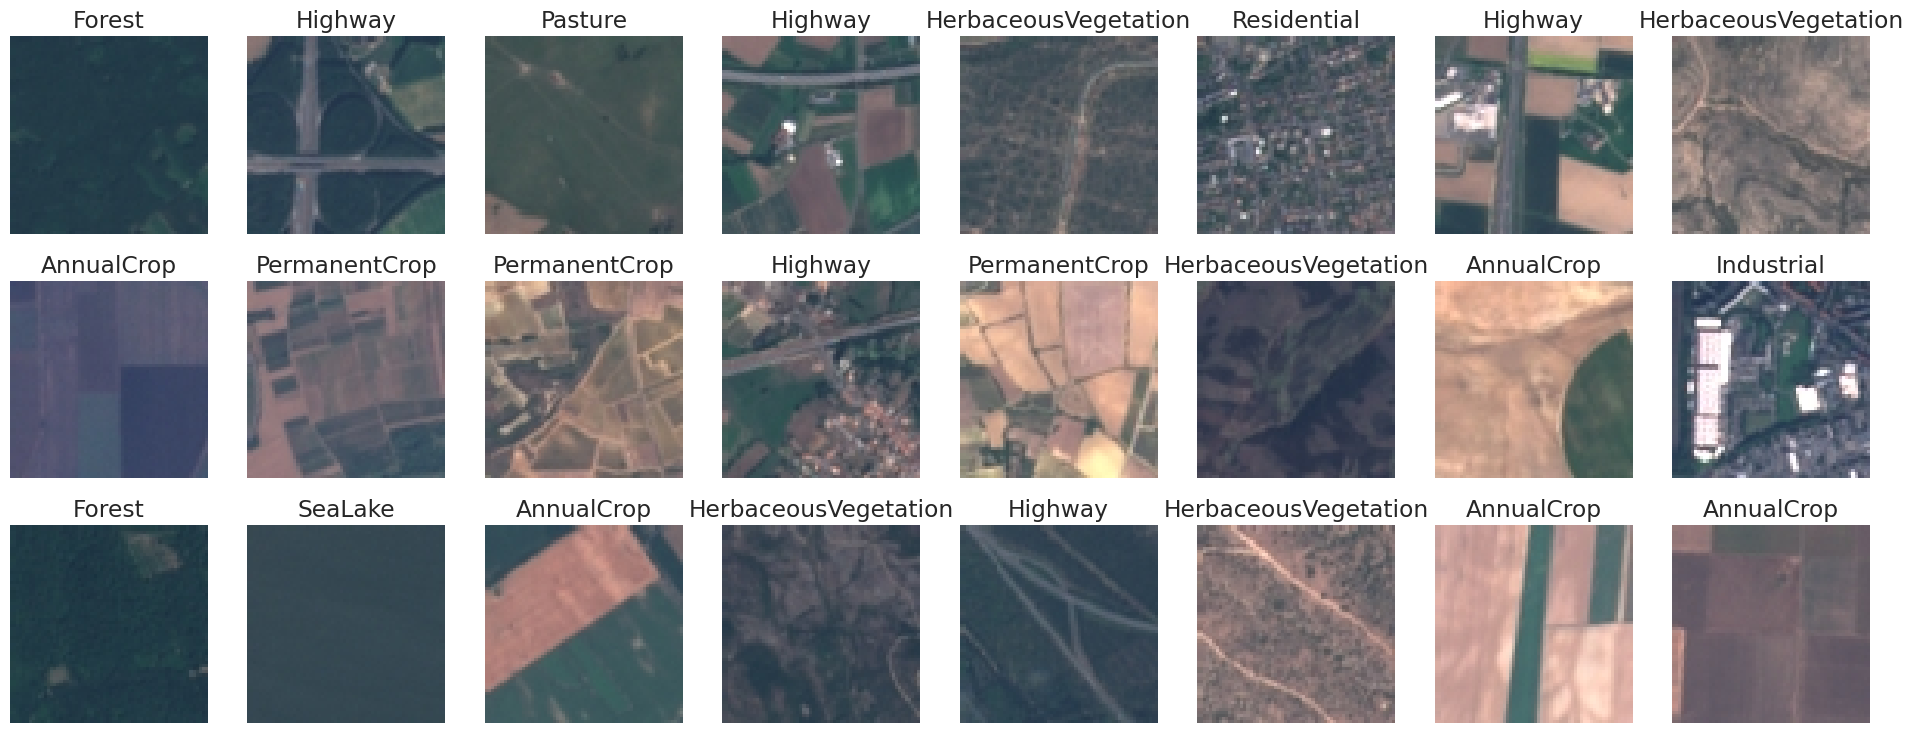

In [35]:

files=glob.glob(r'/home/cez208302/Igarss_CNN/EuroSAT/*/*')
random=np.random.randint(0,len(files),24)
fig,ax=plt.subplots(3,8,figsize=(24,9))
k=0
for i in range(3):
    for j in range(8):
        
        labels=files[random[k]].split('/')[-2]
        plot_images=plt.imread(files[random[k]])
        k=k+1
        ax[i,j].imshow(plot_images)
        ax[i,j].set_title(labels)
        ax[i,j].axis('off')
        ax[i,j].grid(False)
plt.show()

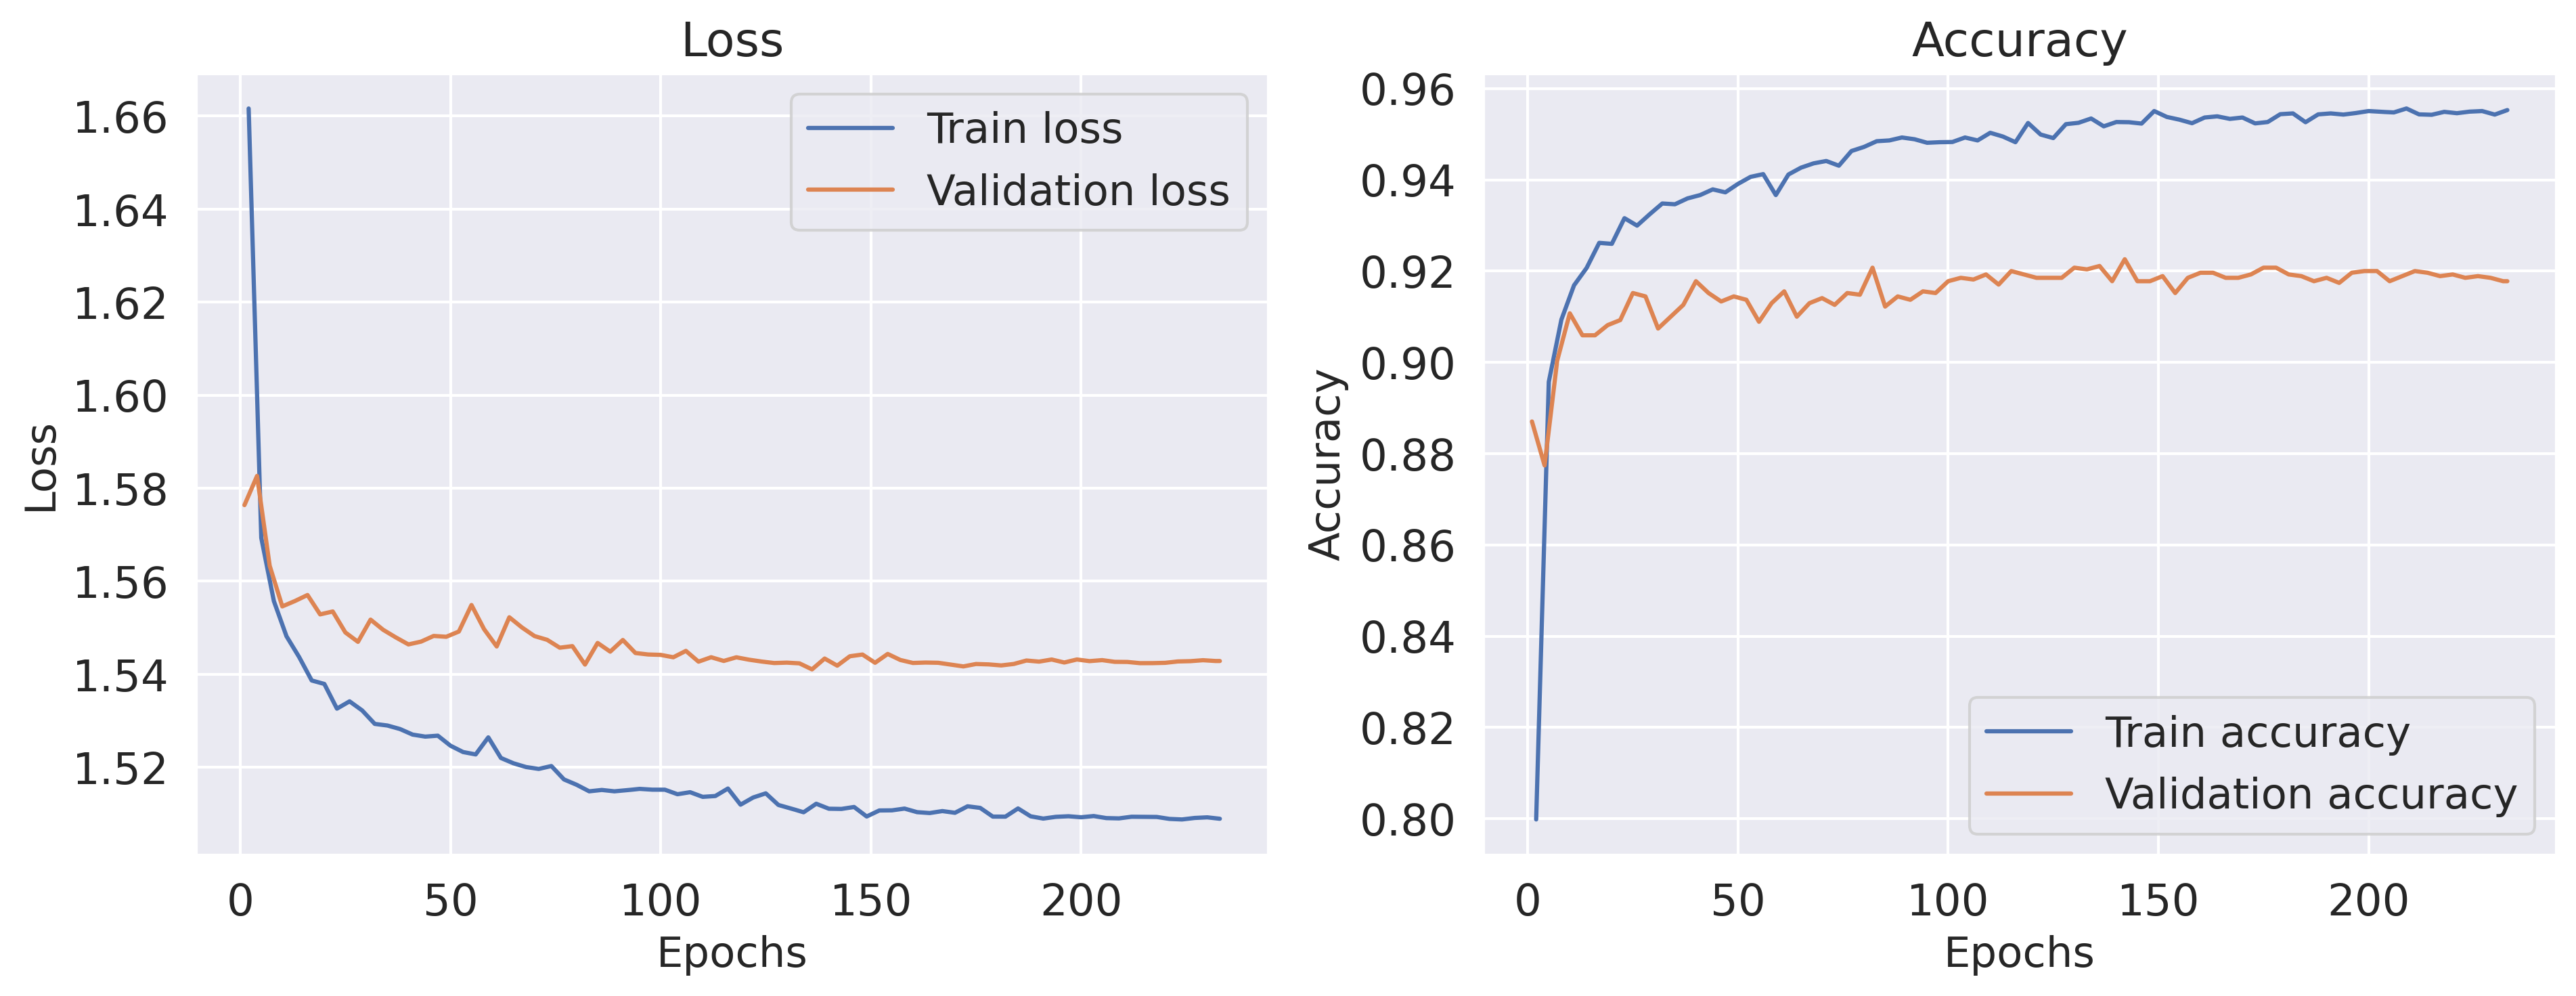

In [37]:
import pandas as pd
file=pd.read_csv(r'/home/cez208302/Igarss_CNN/logs/csvswin/version_7/metrics.csv')
file=file.interpolate(method='linear', axis=0)
font = { 'size': 15, 'color':  'black', 'weight': 'normal', 'verticalalignment': 'baseline', 'horizontalalignment': 'center'}
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi=300)
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
# plot loss
ax[0].plot(file['loss_train'], label='Train loss')
ax[0].plot(file['loss_val'], label='Validation loss')
ax[0].legend(loc='upper right', prop={'size': 15})
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)

ax[1].plot(file['acc_train'], label='Train accuracy')
ax[1].plot(file['acc_val'], label='Validation accuracy')
ax[1].legend(loc='lower right', prop={'size': 15})
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy', fontsize = 15)
plt.show()

In [17]:

def plot_train_images(train_images,train_labels,class_labels):   
    """Plot random train images with labels for EDA"""
    random=np.random.randint(0,train_images.shape[0],16)
    plot_images=train_images[random]
    labels=class_labels[np.argmax(train_labels[random],axis=1)]
    fig,ax=plt.subplots(4,4,figsize=(20,20))
    for i in range(4):
        for j in range(4):
            ax[i,j].imshow(plot_images[i*4+j])
            ax[i,j].set_title(labels[i*4+j])
            ax[i,j].axis('off')
            ax[i,j].grid(False)
    plt.show()

In [ ]:
def check_accuracy_eurosat_challenge(loader, model):
    num_correct, num_samples = 0, 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [ ]:
cpu_size=os.cpu_count()
if batch_size<=cpu_size:
    num_workers = batch_size
else:
    num_workers=cpu_size

In [ ]:
model=timm.create_model("swin_tiny_patch4_window7_224",img_size=64, pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.head.fc=nn.Linear(in_features=768, out_features=10, bias=True)
model.head.fc.requires_grad_(True)

In [ ]:
loss=nn.CrossEntropyLoss()

In [ ]:

##############################
# # codebase
class lightning_model(pl.LightningModule):
    def __init__(self, model, loss_fn, learning_rate):
        super().__init__()
        self.model=model
        self.loss=loss_fn
        self.learning_rate=learning_rate
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self,batch,batch_idx):
        num_correct, num_samples = 0, 0
        x,y = batch
        preds=torch.softmax(self(x),dim=1)
        losses_train=self.loss(preds,y)
        pred=preds.argmax(dim=1)
        num_correct += (pred == y).sum()
        num_samples += pred.size(0)
        acc_train = float(num_correct) / num_samples
        self.log_dict({'loss_train':losses_train,'acc_train':acc_train},on_epoch=True,on_step=False,prog_bar=True)
        return losses_train
    
    def validation_step(self,batch,batch_idx):
        num_correct, num_samples = 0, 0
        x,y = batch
        preds=torch.softmax(self(x),dim=1)
        losses_val=self.loss(preds,y)
        pred=preds.argmax(dim=1)
        num_correct += (pred == y).sum()
        num_samples += pred.size(0)
        acc_val = float(num_correct) / num_samples
        self.log_dict({'loss_val':losses_val,'acc_val':acc_val},on_epoch=True,on_step=False,prog_bar=True)
        return losses_val

    def configure_optimizers(self):

        optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.learning_rate)        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=10,verbose=True )
        lr_scheduler = {"scheduler": scheduler,"interval": "epoch","monitor": "acc_val"} 
        return [optimizer], [lr_scheduler]



In [ ]:
learning_rate=0.01
light_model=lightning_model(model=model,loss_fn=loss,learning_rate=learning_rate)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
        monitor="acc_val",
        patience=30,
        # check_finite=True,
        mode="max",
        verbose=True)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=log+f"./best_model_swin",
        monitor="acc_val",
        mode="max",
        verbose=True,)

trainer = pl.Trainer(
        accelerator="gpu", 
        devices=1, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs, 
        precision=16,
        # profiler='simple',
        logger=[pl.loggers.TensorBoardLogger(log, name=f'swin'),pl.loggers.CSVLogger(log,f'csvswin')],
        callbacks=[lr_monitor,early_stop_callback,checkpoint_callback])

trainer.fit(light_model,train_loader,val_loader)

In [ ]:
light_model=lightning_model.load_from_checkpoint('/home/cez208302/Igarss_CNN/logs./best_model_swin/epoch=57-step=696.ckpt',model=model,loss_fn=loss,learning_rate=learning_rate)
check_accuracy_eurosat_challenge(test_loader,light_model)

In [23]:
x,y=next(iter(test_loader))
x = x.to(device=device)  # move to device, e.g. GPU
y = y.to(device=device, dtype=torch.long)
light_model.cuda()
scores = light_model(x)
_, preds = scores.max(1)

In [24]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean, std)

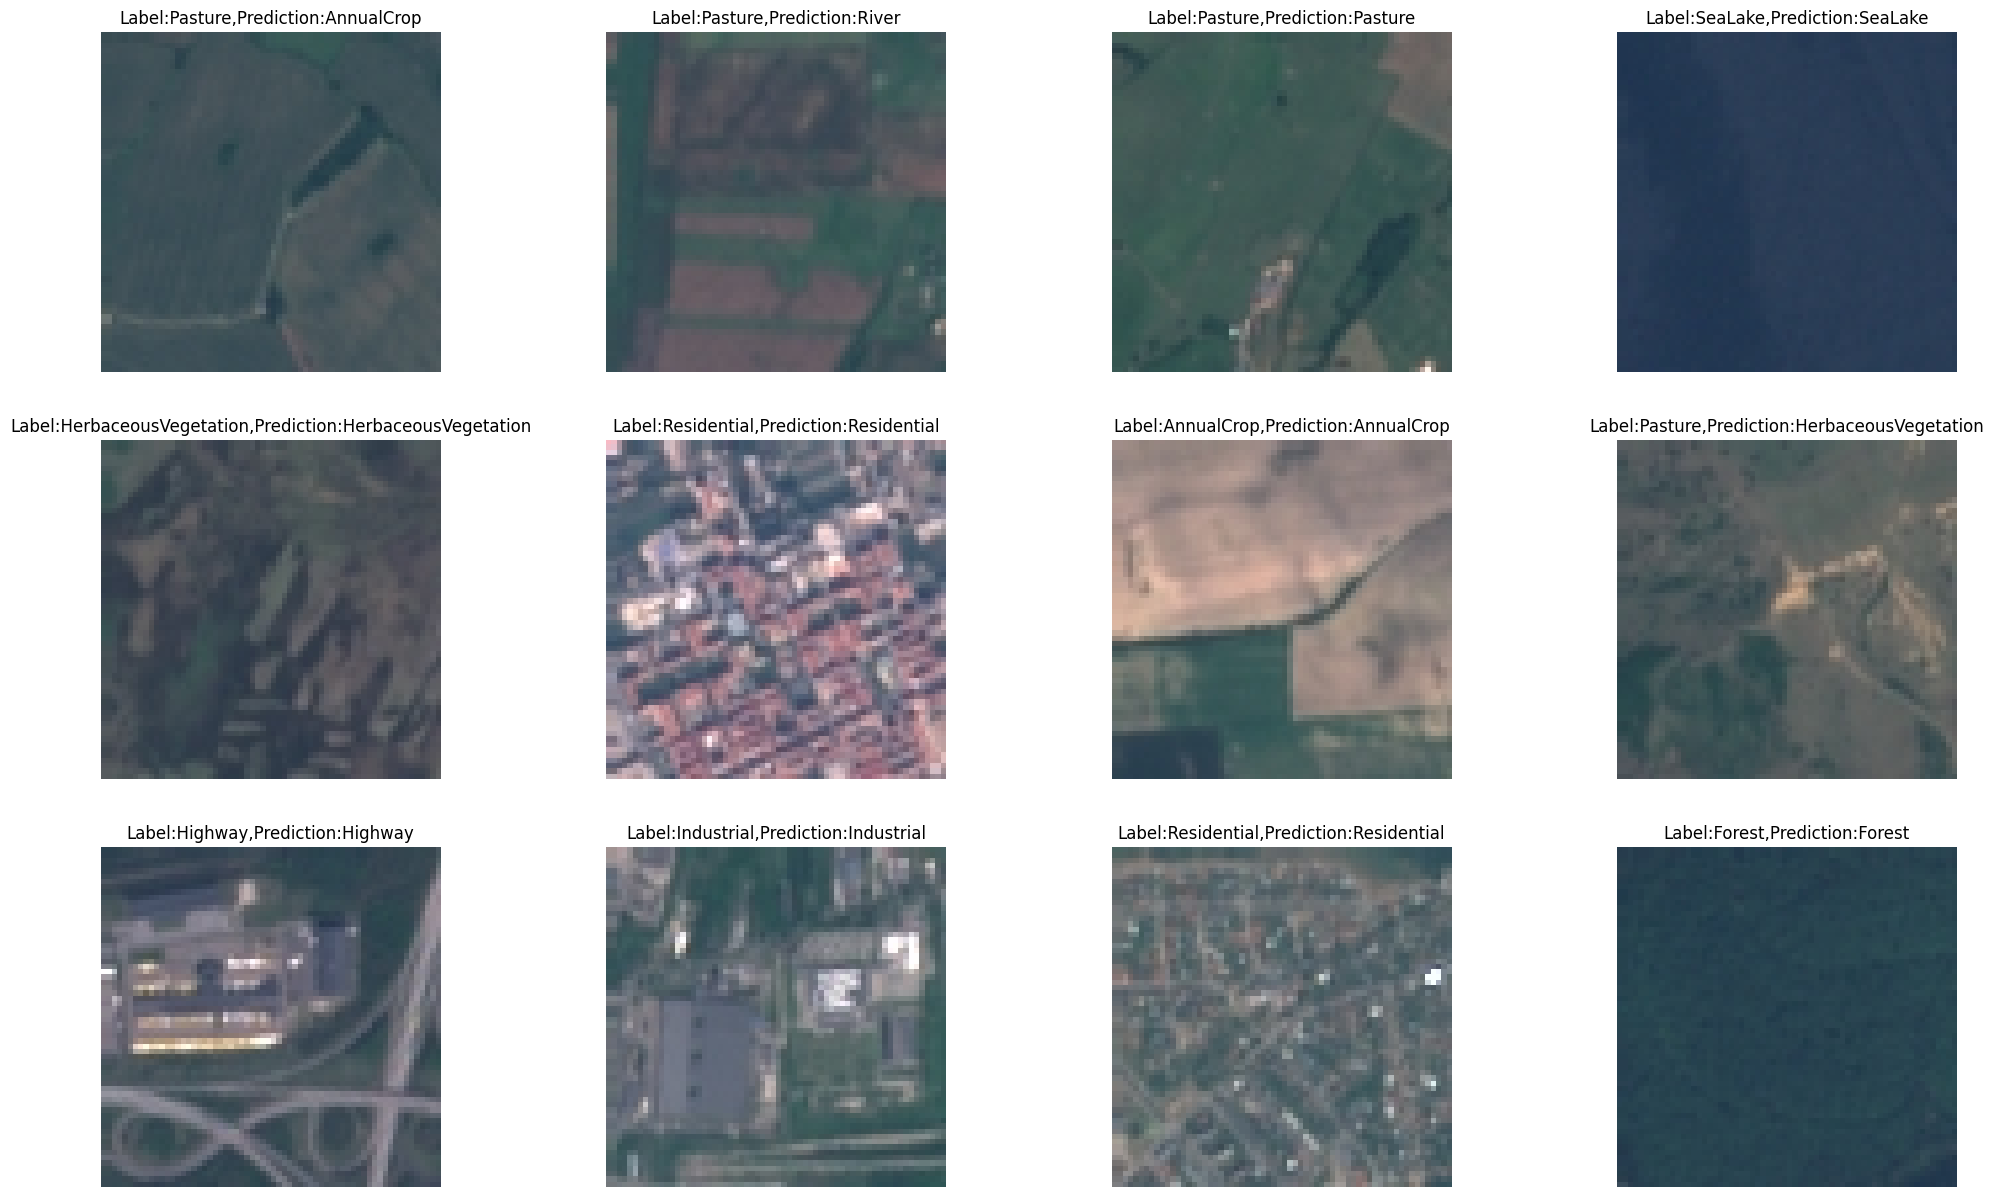

In [25]:
random=np.random.randint(0,1000,25)
fig,ax=plt.subplots(3,4,figsize=(25,15))
k=0
for i in range(3):
    for j in range(4):
        k=k+1
        plot_images=unorm(x[random[k]]).permute(1,2,0).cpu()
        label=eurosat_dataset.classes[y[random[k]].cpu().numpy()]
        prediction=eurosat_dataset.classes[preds[random[k]].cpu().numpy()]
        ax[i,j].imshow(plot_images)
        ax[i,j].set_title(f'Label:{label},Prediction:{prediction}')
        ax[i,j].axis('off')
        ax[i,j].grid(False)

In [26]:
def check_accuracy_eurosat_challenge(loader, model):
    num_correct, num_samples = 0, 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [28]:
check_accuracy_eurosat_challenge(test_loader,light_model)

Got 923 / 1000 correct (92.30)


In [30]:
light_model.eval()  # set model to evaluation mode
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)

In [31]:
from sklearn.metrics import confusion_matrix
cnf_mat = confusion_matrix(y.cpu(), preds.cpu(),normalize='true')
classes=eurosat_dataset.classes
df_cm = pd.DataFrame(cnf_mat, columns=classes, index = classes)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted Label'
plt.figure(figsize = (20,15),dpi=600)
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.xlabel('Predicted Label', fontsize=30)
plt.ylabel('True Label', fontsize=30)
plt.show()